In [1]:
import pandas as pd
import pickle
import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
#from LogIn import LogIn
#kite = LogIn().return_kite_obj()

In [3]:
budget_df = pd.read_csv('budget.csv')

In [4]:
budget_df

,instrument,budget,return
0,NSE:UNIONBANK,400,0.02
1,NSE:DCBBANK,400,0.02
2,NSE:YESBANK,400,0.02
3,NSE:WIPRO,400,0.02
4,NSE:TATASTEEL,400,0.02
5,NSE:SBIN,400,0.02
6,NSE:PNB,400,0.02
7,NSE:ONGC,400,0.02
8,NSE:OIL,400,0.02
9,NSE:NTPC,400,0.02


# Inputs

In [5]:
from_date = '2016-01-01'
to_date = '2016-12-31'

In [6]:
leverage = 15
exit_time = dt.time(15, 10)

# Process

In [7]:
# Download data of all companies
download = False

if download:
    for instrument in budget_df.instrument.tolist():

        try:
            print('------------')
            print(instrument)
            instrument_token = kite.ohlc(instrument)[instrument]['instrument_token']
            data = kite.historical_data(instrument_token=instrument_token, from_date=from_date, to_date=to_date, interval='minute', continuous=False)
            data_df = pd.DataFrame(data)
            data_df.to_pickle('./data/{}_{}_{}.pkl'.format(instrument, from_date, to_date))

        except Exception as ex:
            print('Failed for {} : {}'.format(instrument, ex))

In [8]:
def get_clean_data(instrument, from_date, to_date):
    
    print(instrument)
    data_df = pd.read_pickle('./data/{}_{}_{}.pkl'.format(instrument, from_date, to_date))
    data_df.rename(columns={'date':'timestamp'}, inplace=True)
    data_df['date'] = data_df['timestamp'].dt.date
    data_df['day'] = data_df['timestamp'].dt.day_name()
    print(len(data_df))

    sanity_check = data_df.groupby('date').count().reset_index()
    incomplete_data_days = sanity_check[sanity_check['volume']<300]
    print(incomplete_data_days)

    data_df = data_df[~data_df['date'].isin(incomplete_data_days.date.tolist())]
    data_df['instrument'] = instrument
    print(len(data_df)/375)
    
    return data_df

In [9]:
header_list = ['instrument', 'high_prev', 'low_prev', 'open_today', 'condition', 'transaction_type', 'trade_number', 'level', 'budget', 'return', 'daily_khwab', 'actual_khwab', 'quantity', 'budget_required', 'price', 'trigger_price', 'squareoff', 'stoploss', 'order_id', 'timestamp', 'order_type', 'status', 'profit', 'pl_tag', 'flag', 'adhoora_khwab']


In [10]:
calculate = False

if calculate:
    
    all_trades = pd.DataFrame(columns=header_list)

    for instrument in budget_df.instrument.tolist():

        try:
            data_df = get_clean_data(instrument, from_date, to_date)

            for i in range(len(data_df.date.unique().tolist())-1):

                date_prev = data_df.date.unique().tolist()[i]
                data_prev = data_df[data_df['date']==date_prev]
                open_prev = data_prev.open.iloc[0]
                close_prev = data_prev.open.iloc[-1]
                high_prev = data_prev.high.max()
                low_prev = data_prev.low.min()

                date_today = data_df.date.unique().tolist()[i+1]
                data_today = data_df[data_df['date']==date_today]

                # Trim beyond exit time
                data_today = data_today[data_today['timestamp'].dt.time<exit_time]
                open_today = data_today.open.iloc[0]

                if (open_today > high_prev) & (open_today < 1.15 * high_prev):

                    condition = 'high'
                    transaction_type = 'sell'

                elif (open_today < low_prev) & (open_today > 0.85 * low_prev):

                    condition = 'low'
                    transaction_type = 'buy'

                else:

                    condition = None
                    transaction_type = None

                if condition is not None:

                    valid_trades = all_trades[(all_trades['instrument']==instrument) & (all_trades['condition']==condition) & (all_trades['status']=='complete')]
                    last_valid_trade = valid_trades[valid_trades['trade_number']==valid_trades['trade_number'].max()]

                    # Calculate trade number
                    if len(last_valid_trade):
                        trade_number = int(last_valid_trade['trade_number']) + 1
                    else:
                        trade_number = 1

                    # Calculate level
                    if len(last_valid_trade):
                        if float(last_valid_trade['pl_tag'])==1.0:
                            level = 1
                        else:
                            level = float(last_valid_trade['level']) + 1
                    else:
                        level = 1

                    # Calculate budget and return
                    if level==1:
                        budget = float(budget_df[budget_df['instrument']==instrument]['budget'])
                        return_ = float(budget_df[budget_df['instrument']==instrument]['return'])
                    else:
                        budget = float(last_valid_trade['budget'])
                        return_ = float(last_valid_trade['return'])

                    # Calculate daily khwab
                    if len(last_valid_trade):
                        if int(last_valid_trade['flag'])==1:
                            daily_khwab = round(return_ * budget, 2)
                        else:
                            daily_khwab = 0
                    else:
                        daily_khwab = round(return_ * budget, 2)

                    # Calculate actual khwab
                    if len(last_valid_trade):
                        actual_khwab = max(round(float(last_valid_trade['adhoora_khwab']) + daily_khwab, 2), round(return_ * budget, 2))
                    else:
                        actual_khwab = round(return_ * budget, 2)

                    # Calculate quantity
                    quantity = int(round(actual_khwab/(return_ * open_today)))

                    # Calculate budget required
                    budget_required = round(quantity * open_today, 2)

                    # Calculate price and trigger price
                    if transaction_type=='buy':
                        price = round(open_today + 0.05 * max(round(20 * 0.0010 * open_today), 2), 2)
                        trigger_price = round(open_today + 0.05 * max(round(20 * 0.0005 * open_today),1), 2)
                    else:
                        price = round(open_today - 0.05 * max(round(20 * 0.0010 * open_today), 2), 2)
                        trigger_price = round(open_today - 0.05 * max(round(20 * 0.0005 * open_today),1), 2)

                    # Calculate square off and stoploss
                    squareoff = round(return_ * price, 1)
                    stoploss = round(return_ * price, 1)

                    # Calculate order_id, order_type
                    order_id = trade_number
                    order_type = 'SL'

                    # Calculate timestamp, status and profit
                    if transaction_type=='buy':

                        if data_today.high.max() < trigger_price:

                            timestamp = data_today.timestamp.iloc[0]
                            status = 'incomplete'
                            profit = 0

                        else:

                            status = 'complete'
                            for index, row in data_today.iterrows():

                                if row['high'] > price + squareoff:
                                    timestamp = row['timestamp']
                                    profit = round(squareoff * quantity, 2)
                                    break

                                elif row['low'] < price - stoploss:
                                    timestamp = row['timestamp']
                                    profit = round(-1 * stoploss * quantity, 2)
                                    break

                                else:
                                    timestamp = row['timestamp']
                                    profit = round((row['close']-price) * quantity, 2)

                    else:

                        if data_today.low.min() > trigger_price:
                            timestamp = data_today.timestamp.iloc[0]
                            status = 'incomplete'
                            profit = 0            

                        else:

                            status = 'complete'
                            for index, row in data_today.iterrows():

                                if row['low'] < price - squareoff:
                                    timestamp = row['timestamp']
                                    profit = round(squareoff * quantity, 2)
                                    break

                                elif row['high'] > price + stoploss:
                                    timestamp = row['timestamp']
                                    profit = round(-1 * stoploss * quantity, 2)
                                    break

                                else:
                                    timestamp = row['timestamp']
                                    profit = round((price - row['close']) * quantity, 2)

                    # Calculate P/L tag
                    pl_tag = round(round(float(profit), 2) / (float(squareoff) * float(quantity)), 1)

                    # Calculate flag
                    if abs(float(pl_tag))==1:
                        flag = 1
                    else:
                        flag = 0

                    # Calculate adhoora khwab
                    adhoora_khwab = round(float(actual_khwab) - profit, 2)

                    trades_today = pd.DataFrame(data={'instrument':[instrument], 
                                                      'high_prev':[high_prev], 
                                                      'low_prev':[low_prev], 
                                                      'open_today':[open_today], 
                                                      'condition':[condition], 
                                                      'transaction_type':[transaction_type], 
                                                      'trade_number':[trade_number], 
                                                      'level':[level], 
                                                      'budget':[budget], 
                                                      'return':[return_], 
                                                      'daily_khwab':[daily_khwab], 
                                                      'actual_khwab':[actual_khwab], 
                                                      'quantity':[quantity], 
                                                      'budget_required':[budget_required], 
                                                      'price':[price], 
                                                      'trigger_price':[trigger_price], 
                                                      'squareoff':[squareoff], 
                                                      'stoploss':[stoploss], 
                                                      'order_id':[order_id], 
                                                      'timestamp':[timestamp], 
                                                      'order_type':[order_type], 
                                                      'status':[status], 
                                                      'profit':[profit], 
                                                      'pl_tag':[pl_tag], 
                                                      'flag':[flag], 
                                                      'adhoora_khwab':[adhoora_khwab]
                                                     })

                    all_trades = all_trades.append(trades_today, ignore_index = True)
        except Exception as ex:
            print('Failed calculation for {} : {}'.format(instrument, ex))
            
    all_trades.to_pickle('all_trades_opp_{}_{}.pkl'.format(from_date, to_date))
    
else:
    
    all_trades = pd.read_pickle('all_trades_opp_{}_{}.pkl'.format(from_date, to_date))

# High Trades Analysis

In [11]:
high_trades = all_trades[(all_trades['condition']=='high') & (all_trades['status']=='complete')]

In [12]:
high_trades_loop = pd.DataFrame()
for instrument in high_trades.instrument.unique().tolist():
    instrument_high_trades = high_trades[high_trades['instrument']==instrument]
    instrument_high_trades_loop = instrument_high_trades[instrument_high_trades['trade_number']<=instrument_high_trades[instrument_high_trades['pl_tag']==1.0].trade_number.max()]
    high_trades_loop = high_trades_loop.append(instrument_high_trades_loop, ignore_index=True)
    

In [13]:
high_trades[high_trades['budget_required']==high_trades['budget_required'].max()]

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
48,NSE:UNIONBANK,145.2,139.75,145.3,high,sell,32,12,400.0,0.02,8.0,4700.8,1618,235095.4,145.45,145.35,2.9,2.9,32,2016-09-15 10:09:00+05:30,SL,complete,4692.2,1.0,1,8.6


In [26]:
low_trades[low_trades['instrument']=='NSE:PFC']

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
1910,NSE:PFC,102.73,99.45,98.50,low,buy,1,1,400.0,0.02,8.0,8.00,4,394.00,98.40,98.45,2.0,2.0,1,2016-01-07 11:09:00+05:30,SL,complete,-8.00,-1.0,1,16.00
1911,NSE:PFC,95.98,94.30,93.45,low,buy,2,2,400.0,0.02,8.0,24.00,13,1214.85,93.35,93.40,1.9,1.9,2,2016-01-11 14:10:00+05:30,SL,complete,24.70,1.0,1,-0.70
1912,NSE:PFC,87.78,84.30,82.68,low,buy,3,1,400.0,0.02,8.0,8.00,5,413.40,82.58,82.63,1.7,1.7,3,2016-02-03 10:27:00+05:30,SL,complete,-8.50,-1.0,1,16.50
1913,NSE:PFC,77.23,71.58,71.48,low,buy,4,2,400.0,0.02,8.0,24.50,17,1215.16,71.38,71.43,1.4,1.4,4,2016-02-17 10:34:00+05:30,SL,complete,23.80,1.0,1,0.70
1915,NSE:PFC,76.83,75.30,75.25,low,buy,5,1,400.0,0.02,8.0,8.70,6,451.50,75.15,75.20,1.5,1.5,5,2016-02-24 15:09:00+05:30,SL,complete,-1.32,-0.1,0,10.02
1919,NSE:PFC,86.88,83.85,83.53,low,buy,6,2,400.0,0.02,0.0,10.02,6,501.18,83.43,83.48,1.7,1.7,6,2016-03-29 15:09:00+05:30,SL,complete,-3.00,-0.3,0,13.02
1920,NSE:PFC,86.23,84.40,83.83,low,buy,7,3,400.0,0.02,0.0,13.02,8,670.64,83.73,83.78,1.7,1.7,7,2016-05-11 14:28:00+05:30,SL,complete,-13.60,-1.0,1,26.62
1922,NSE:PFC,87.38,85.03,85.00,low,buy,8,4,400.0,0.02,8.0,34.62,20,1700.00,84.90,84.95,1.7,1.7,8,2016-05-18 10:44:00+05:30,SL,complete,34.00,1.0,1,0.62
1924,NSE:PFC,83.10,81.50,81.23,low,buy,9,1,400.0,0.02,8.0,8.62,5,406.15,81.13,81.18,1.6,1.6,9,2016-06-13 12:11:00+05:30,SL,complete,-8.00,-1.0,1,16.62
1926,NSE:PFC,83.60,82.43,81.25,low,buy,10,2,400.0,0.02,8.0,24.62,15,1218.75,81.15,81.20,1.6,1.6,10,2016-06-24 09:49:00+05:30,SL,complete,-24.00,-1.0,1,48.62


# Low Trades Analysis

In [14]:
low_trades = all_trades[(all_trades['condition']=='low') & (all_trades['status']=='complete')]

In [15]:
low_trades_loop = pd.DataFrame()
for instrument in low_trades.instrument.unique().tolist():
    instrument_low_trades = low_trades[low_trades['instrument']==instrument]
    instrument_low_trades_loop = instrument_low_trades[instrument_low_trades['trade_number']<=instrument_low_trades[instrument_low_trades['pl_tag']==1.0].trade_number.max()]
    low_trades_loop = low_trades_loop.append(instrument_low_trades_loop, ignore_index=True)
    

In [16]:
low_trades.head()

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
0,NSE:UNIONBANK,146.50,142.20,140.50,low,buy,1,1,400.0,0.02,8.0,8.00,3,421.50,140.35,140.45,2.8,2.8,1,2016-01-07 11:39:00+05:30,SL,complete,-8.40,-1.0,1,16.40
1,NSE:UNIONBANK,138.60,136.05,134.60,low,buy,2,2,400.0,0.02,8.0,24.40,9,1211.40,134.45,134.55,2.7,2.7,2,2016-01-11 12:27:00+05:30,SL,complete,-24.30,-1.0,1,48.70
2,NSE:UNIONBANK,117.50,112.00,111.45,low,buy,3,3,400.0,0.02,8.0,56.70,25,2786.25,111.35,111.40,2.2,2.2,3,2016-01-20 14:08:00+05:30,SL,complete,-55.00,-1.0,1,111.70
5,NSE:UNIONBANK,133.65,125.50,123.10,low,buy,4,4,400.0,0.02,8.0,119.70,49,6031.90,123.00,123.05,2.5,2.5,4,2016-02-03 15:09:00+05:30,SL,complete,-22.05,-0.2,0,141.75
7,NSE:UNIONBANK,136.60,128.25,128.00,low,buy,5,5,400.0,0.02,0.0,141.75,55,7040.00,127.85,127.95,2.6,2.6,5,2016-02-10 09:31:00+05:30,SL,complete,-143.00,-1.0,1,284.75


# Results

In [17]:
pd.DataFrame(data={'high':[len(high_trades),
                           len(high_trades_loop),
                           round(high_trades_loop.profit.sum(), 2), 
                           round(high_trades_loop.profit.sum()/budget_df.budget.sum() * 100, 2),
                           round(high_trades_loop.budget_required.max()), 
                           round(high_trades_loop.budget_required.max()/leverage)],
                   'low':[len(low_trades),
                          len(low_trades_loop),
                          round(low_trades_loop.profit.sum(), 2), 
                          round(low_trades_loop.profit.sum()/budget_df.budget.sum() * 100, 2),
                          round(low_trades_loop.budget_required.max()),
                          round(low_trades_loop.budget_required.max()/leverage)]
                   }, 
             index = ['total_trades', 'trades_considered', 'profit', 'perc_return', 'hightest_budget_required', 'hightest_margin_required'])

,high,low
total_trades,1898.00,1239.00
trades_considered,1748.00,1130.00
profit,8755.61,6551.80
perc_return,31.16,23.32
hightest_budget_required,235095.00,107611.00
hightest_margin_required,15673.00,7174.00


# Daily Margin Required Analysis

In [18]:
all_trades['date'] = all_trades['timestamp'].dt.date
all_trades['margin_required'] = all_trades['budget_required']/leverage
margins = all_trades.groupby('date').agg({'budget_required':sum, 'margin_required':sum, 'instrument':list}).reset_index()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels, rotation='vertical')

    if y_label:
        plt.ylabel(y_label)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

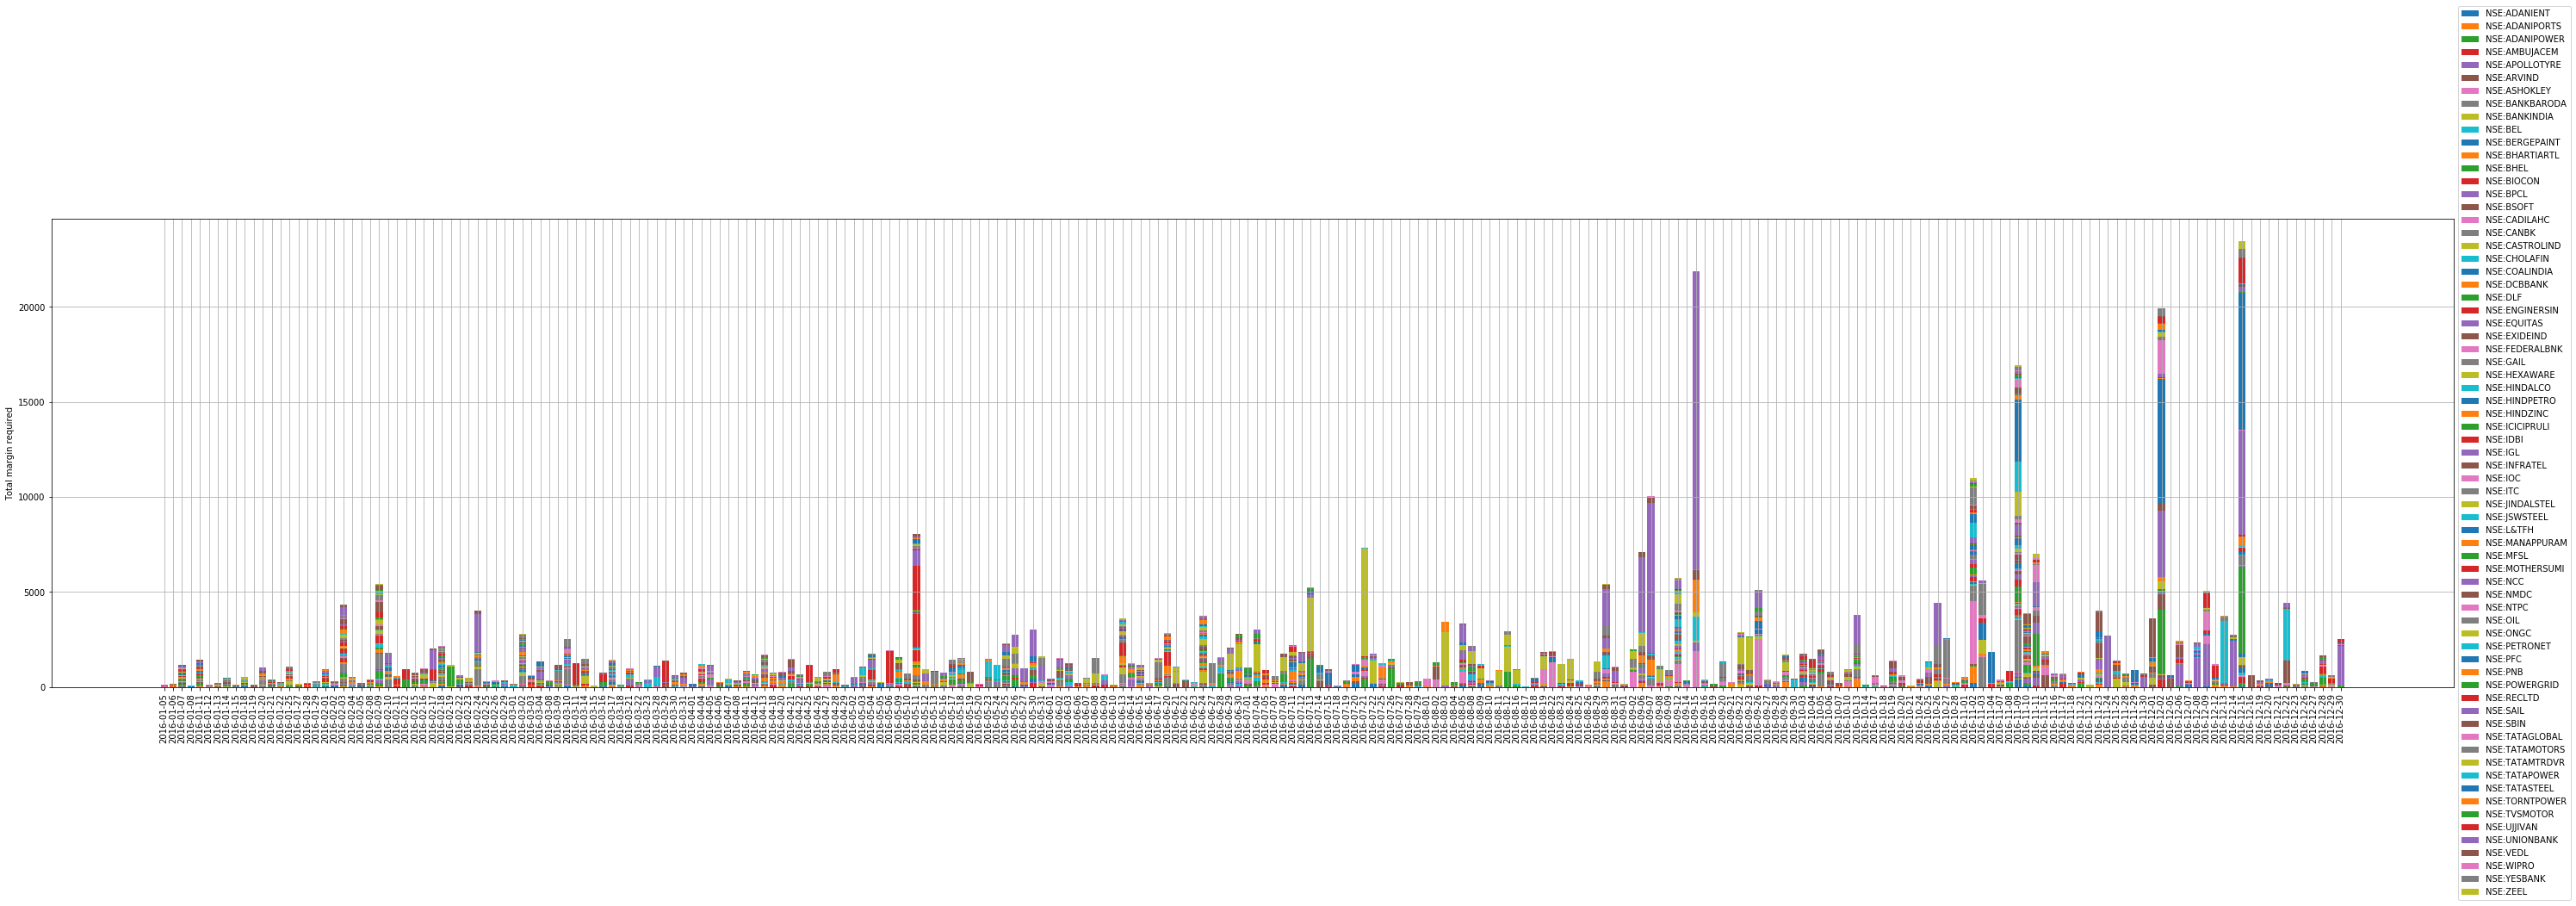

In [20]:
df2 = all_trades.groupby(['date', 'instrument'])['margin_required'].sum().unstack('instrument').fillna(0)

df = df2.transpose()

plt.figure(figsize=(50, 10))

series_labels = df.index.tolist()

data = df.values

category_labels = df.columns.tolist()

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=False,
    value_format="{:.1f}",
    y_label="Total margin required"
)

plt.savefig('margin_required_opp_{}_{}.png'.format(from_date, to_date))
plt.show()

In [24]:
df2

instrument,NSE:ADANIENT,NSE:ADANIPORTS,NSE:ADANIPOWER,NSE:AMBUJACEM,NSE:APOLLOTYRE,NSE:ARVIND,NSE:ASHOKLEY,NSE:BANKBARODA,NSE:BANKINDIA,NSE:BEL,NSE:BERGEPAINT,NSE:BHARTIARTL,NSE:BHEL,NSE:BIOCON,NSE:BPCL,NSE:BSOFT,NSE:CADILAHC,NSE:CANBK,NSE:CASTROLIND,NSE:CHOLAFIN,NSE:COALINDIA,NSE:DCBBANK,NSE:DLF,NSE:ENGINERSIN,NSE:EQUITAS,NSE:EXIDEIND,NSE:FEDERALBNK,NSE:GAIL,NSE:HEXAWARE,NSE:HINDALCO,NSE:HINDPETRO,NSE:HINDZINC,NSE:ICICIPRULI,NSE:IDBI,NSE:IGL,NSE:INFRATEL,NSE:IOC,NSE:ITC,NSE:JINDALSTEL,NSE:JSWSTEEL,NSE:L&TFH,NSE:MANAPPURAM,NSE:MFSL,NSE:MOTHERSUMI,NSE:NCC,NSE:NMDC,NSE:NTPC,NSE:OIL,NSE:ONGC,NSE:PETRONET,NSE:PFC,NSE:PNB,NSE:POWERGRID,NSE:RECLTD,NSE:SAIL,NSE:SBIN,NSE:TATAGLOBAL,NSE:TATAMOTORS,NSE:TATAMTRDVR,NSE:TATAPOWER,NSE:TATASTEEL,NSE:TORNTPOWER,NSE:TVSMOTOR,NSE:UJJIVAN,NSE:UNIONBANK,NSE:VEDL,NSE:WIPRO,NSE:YESBANK,NSE:ZEEL
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.813333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.106000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.165333,0.000000,0.000000
2016-01-06,0.000000,33.893333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.233333,0.000000,0.000000,20.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.946667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.333333,0.000000,0.000000,0.000000,26.156000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-07,28.216667,32.746667,0.000000,0.000000,30.700000,23.533333,24.426667,0.000000,0.000000,0.000000,0.000000,0.000000,29.165333,28.616667,0.000000,21.720000,0.000000,29.966667,29.210667,0.000000,0.000000,26.466667,30.066667,23.520000,0.000000,28.190000,25.386667,27.613333,31.866667,26.333333,0.000000,28.800000,0.000000,27.033333,0.000000,0.000000,0.000000,27.830667,24.266667,27.733333,25.920000,0.000000,33.800000,24.730000,0.000000,23.946667,0.000000,26.398667,30.954000,0.000000,26.266667,28.866667,0.000000,30.048000,25.946667,28.506667,28.830000,23.800000,17.850000,27.180000,34.973333,0.000000,18.933333,0.000000,28.100000,28.800000,0.000000,27.700000,0.000000
2016-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.476000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-11,0.000000,31.533333,0.000000,0.000000,0.000000,0.000000,0.000000,27.610000,29.040000,0.000000,0.000000,0.000000,81.016000,0.000000,0.000000,73.826667,40.933333,86.880000,0.000000,25.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.933333,0.000000,0.000000,0.000000,0.000000,0.000000,29.866667,26.100000,0.000000,0.000000,0.000000,0.000000,38.220000,0.000000,97.400000,79.066667,24.266667,0.000000,0.000000,0.000000,0.000000,25.800000,80.990000,82.520000,0.000000,85